# Аналитика в Яндекс.Афише

1. [Описание и цели](#objectives)
2. [Обзор и предобработка данных](#preprocessing)
3. [Метрики](#metrics)
    * [Продукт](#product)    
    * [Продажи](#sales)
    * [Маркетинг](#marketing)
8. [Выводы и рекомендации](#summary)

## Описание и цели<a id="objectives"></a>

**В распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:**

   - лог сервера с данными о посещениях сайта Яндекс.Афиши
   - выгрузка всех заказов за этот период,
   - статистика рекламных расходов.

**Необходимо изучить:**

   - как люди пользуются продуктом,
   - когда они начинают покупать,
   - сколько денег приносит каждый клиент
   - когда клиент окупается

## Обзор и предобработка данных<a id="preprocessing"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

visits = pd.read_csv('visits_log.csv') 
orders = pd.read_csv('orders_log.csv') 
costs = pd.read_csv('costs.csv') 

**Просмотр и предобработка таблицы с информацией о посещениях сайта**

In [2]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [3]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
#установим тип данных Дата у колонок начала и окончания сессии

visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')

**Просмотр и предобработка таблицы с информацией о заказах**

In [5]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [6]:
orders.columns = ['buy_ts', 'revenue', 'uid']

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null object
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [8]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [9]:
#проверим, есть ли нулевые значения в поле revenue
orders[orders['revenue']==0]['revenue'].count()

51

In [10]:
#удалим строки с нулевыми значения в поле выручки по заказу
orders = orders[orders['revenue']!=0]

In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50364 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50364 non-null datetime64[ns]
revenue    50364 non-null float64
uid        50364 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.5 MB


**Просмотр и предобработка таблицы с информацией о затратах**

In [12]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [13]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [14]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [15]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [16]:
#проверяем, есть ли нулевые значения в колонке затрат
costs[costs['costs']==0]['costs'].count()

0

## Метрики<a id="metrics"></a>

### Продукт<a id="product"></a>

**Сколько людей пользуются в день, неделю, месяц?**

In [17]:
#сохраним в переменной таблицу visits до изменений
visits_new = visits

#создадим в таблице visits колонки "дата", "неделя", "месяц"

visits['activity_date'] = visits['start_ts'].dt.date
visits['week'] = visits['start_ts'].dt.week
visits['month'] = visits['start_ts'].dt.month

#количество пользователей по дням
users_per_day = visits.groupby('activity_date')['uid'].nunique().reset_index()
users_per_day

,activity_date,uid
0,2017-06-01,605
1,2017-06-02,608
2,2017-06-03,445
3,2017-06-04,476
4,2017-06-05,820
...,...,...
359,2018-05-27,620
360,2018-05-28,1039
361,2018-05-29,948
362,2018-05-30,1289


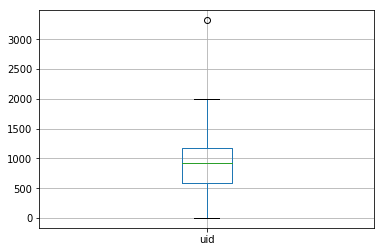

In [18]:
users_per_day.boxplot()

In [19]:
users_per_day.describe()

,uid
count,364.000000
mean,907.991758
std,370.513838
min,1.000000
25%,594.000000
50%,921.000000
75%,1173.000000
max,3319.000000


**Вывод:** В среднем сайт посещают 908 пользователей в день. В особенно успешные дни, количество уникальных пользователей достигает 3319 человек.

**С каких устройств посетители заходят на сайт**

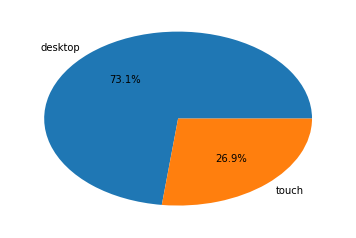

In [20]:
device_visit = visits.groupby('device')['uid'].count().reset_index()
fig1, ax1 = plt.subplots()
ax1.pie(device_visit['uid'], labels=device_visit['device'], autopct='%1.1f%%')
plt.show()

In [21]:
users_per_week = visits.groupby('week')['uid'].nunique()
users_per_week

week
1      6918
2      6703
3      6972
4      7060
5      8111
6      7908
7      7759
8      7518
9      7395
10     6844
11     6225
12     7898
13     4940
14     5383
15     5494
16     5740
17     5503
18     3916
19     4128
20     5070
21     4995
22     6867
23     4129
24     2812
25     2878
26     3064
27     3294
28     4355
29     3841
30     2655
31     2364
32     2444
33     2746
34     3116
35     3694
36     4412
37     4319
38     4874
39     6241
40     7612
41     7074
42     7148
43     7401
44     7480
45     7179
46     8117
47    10586
48     8166
49     8407
50     8214
51     7172
52     7774
Name: uid, dtype: int64

In [22]:
#среднее число пользователей в неделю
round(users_per_week.mean(),0)

5825.0

In [23]:
users_per_month = visits.groupby('month')['uid'].nunique()
users_per_month

month
1     28716
2     28749
3     27473
4     21008
5     20701
6     13259
7     14183
8     11631
9     18975
10    29692
11    32797
12    31557
Name: uid, dtype: int64

In [24]:
round(users_per_month.mean(),0)

23228.0

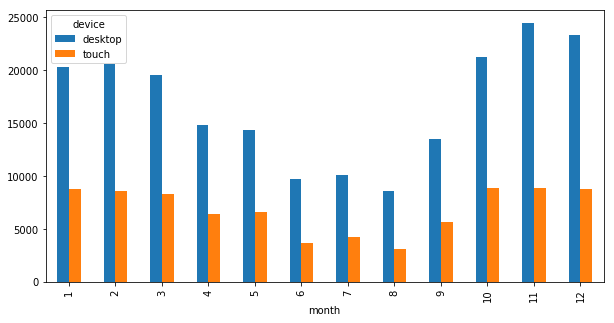

In [25]:
#посетители по месяцам с различных устройств
visits.pivot_table(index='month', columns='device', values='uid', aggfunc='nunique').plot(kind='bar', figsize=(10, 5))

**Из каких источников приходят посетители?**

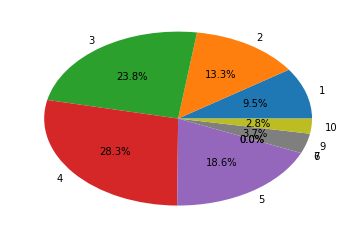

In [26]:
resorses_visit = visits.groupby('source_id')['uid'].count().reset_index()

fig1, ax1 = plt.subplots()
ax1.pie(resorses_visit['uid'], labels=resorses_visit['source_id'], autopct='%1.1f%%')
plt.show()

**Вывод:** Чаще всего пользователей удается привлечь на сайт через рекламные источники под номерами 3 и 4.

**Сколько сессий в день?**

In [27]:
session_per_day = visits.groupby('activity_date')['start_ts'].count()
session_per_day

activity_date
2017-06-01     664
2017-06-02     658
2017-06-03     477
2017-06-04     510
2017-06-05     893
              ... 
2018-05-27     672
2018-05-28    1156
2018-05-29    1035
2018-05-30    1410
2018-05-31    2256
Name: start_ts, Length: 364, dtype: int64

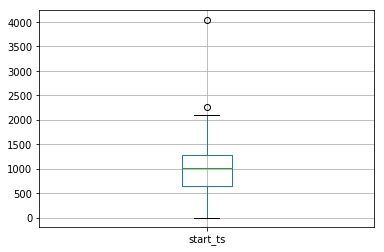

In [28]:
session_per_day.reset_index().boxplot()

In [29]:
#среднее число сессий в день за весь период
round(session_per_day.mean(),0)

987.0

**Сколько длится одна сессия?**

In [30]:
#длительность одной сессии
duration =  visits['end_ts'] - visits['start_ts']
duration.mean()

Timedelta('0 days 00:10:43.025687')

**Вывод:** В среднем на сайт совершается около 1000 визитов в день. Средняя длительность сессии составляет 10 минут.

**Как часто люди возвращаются?**

Для того, чтобы выяснить, возвращаются ли посетители на сайт, сформируем когорты пользователей по дате первого входа на сайт. В периоде увидим, были ли повторные заходы на сайт после первого посещения, а также рассчитаем метрику удержания Retention.

In [31]:
#определим дату первого входа на сайт
first_activity_date = visits.groupby(['uid'])['activity_date'].min()
first_activity_date

uid
11863502262781          2018-03-01
49537067089222          2018-02-06
297729379853735         2017-06-07
313578113262317         2017-09-18
325320750514679         2017-09-30
                           ...    
18446403737806311543    2017-11-30
18446424184725333426    2017-12-06
18446556406699109058    2018-01-01
18446621818809592527    2017-12-27
18446676030785672386    2017-10-04
Name: activity_date, Length: 228169, dtype: object

In [32]:
first_activity_date.name = 'first_activity_date'

In [33]:
visits = visits.join(first_activity_date, on='uid')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 9 columns):
device                 359400 non-null object
end_ts                 359400 non-null datetime64[ns]
source_id              359400 non-null int64
start_ts               359400 non-null datetime64[ns]
uid                    359400 non-null uint64
activity_date          359400 non-null object
week                   359400 non-null int64
month                  359400 non-null int64
first_activity_date    359400 non-null object
dtypes: datetime64[ns](2), int64(3), object(3), uint64(1)
memory usage: 24.7+ MB


In [34]:
visits['first_activity_date'] = pd.to_datetime(visits['first_activity_date'])
visits['activity_date'] = pd.to_datetime(visits['activity_date'])

In [35]:
visits['activity_week'] = pd.to_datetime(visits['activity_date'], unit='d') - pd.to_timedelta(visits['activity_date'].dt.dayofweek, unit='d')

In [36]:
visits['first_activity_week'] = pd.to_datetime(visits['first_activity_date'], unit='d') - pd.to_timedelta(visits['first_activity_date'].dt.dayofweek, unit='d')

In [37]:
visits.head()

,device,end_ts,source_id,start_ts,uid,activity_date,week,month,first_activity_date,activity_week,first_activity_week
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017-12-20,2017-12-18,2017-12-18
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018-02-19,2018-02-19,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017-07-01,2017-06-26,2017-06-26
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018-03-09,2018-05-14,2018-03-05
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017-12-27,2017-12-25,2017-12-25


In [38]:
visits['cohort_lifetime'] = visits['activity_week'] - visits['first_activity_week']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'W')
visits['cohort_lifetime'] = visits['cohort_lifetime'].astype(int)

In [39]:
cohorts = visits.groupby(['first_activity_week','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [40]:
inital_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_week','uid']]
inital_users_count.head()

,first_activity_week,uid
0,2017-05-29,2021
53,2017-06-05,3944
105,2017-06-12,2567
156,2017-06-19,2585
206,2017-06-26,2717


In [41]:
inital_users_count = inital_users_count.rename(columns={'uid':'cohort_users'})

In [42]:
cohorts = cohorts.merge(inital_users_count,on='first_activity_week')

In [43]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']*100

In [44]:
retention_pivot = cohorts.pivot_table(index='first_activity_week',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
first_activity_week,,,,,,,,,,,,,,,,,,,,,
2017-05-29,100.0,9.153884,4.849085,3.661554,4.354280,4.106878,3.711034,3.612073,2.919347,2.226620,...,2.869866,2.226620,2.721425,2.820386,2.919347,2.177140,2.375062,3.018308,3.018308,2.276101
2017-06-05,100.0,3.727181,2.890467,2.535497,2.205882,2.484787,2.180527,1.749493,1.470588,1.800203,...,1.521298,1.546653,1.901623,1.343813,1.293103,1.267748,1.926978,1.774848,1.495943,NaN
2017-06-12,100.0,4.090378,2.610051,2.298403,2.220491,1.986755,1.558239,1.636151,1.324503,1.830931,...,1.363459,1.246591,1.129723,1.051811,1.051811,0.973899,1.363459,0.818076,NaN,NaN
2017-06-19,100.0,3.558994,2.437137,2.437137,2.282398,1.547389,1.276596,0.812379,1.044487,1.392650,...,1.160542,1.160542,1.005803,0.696325,0.967118,1.005803,0.696325,NaN,NaN,NaN
2017-06-26,100.0,3.864556,2.649982,1.987486,1.509017,1.288185,1.140964,1.104159,1.398601,1.472212,...,0.625690,0.515274,0.662495,0.883327,1.030548,0.956938,NaN,NaN,NaN,NaN
2017-07-03,100.0,4.659993,2.899551,2.002071,1.311702,1.484294,1.380739,1.035554,1.311702,1.553331,...,0.414222,0.552295,0.759406,0.448740,0.759406,NaN,NaN,NaN,NaN,NaN
2017-07-10,100.0,3.839170,1.738003,1.322957,1.037613,1.141375,1.271077,1.115435,1.374838,1.219196,...,0.648508,0.830091,0.985733,0.856031,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-17,100.0,3.377967,2.404139,1.399878,1.673767,1.643335,1.552039,1.795496,1.582471,1.704200,...,0.882532,0.730371,0.639075,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-24,100.0,2.442396,1.705069,1.889401,1.474654,1.797235,2.119816,1.474654,1.612903,1.336406,...,0.506912,0.460829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Показатель удержания пользователей по неделям на первый взгляд достаточно низкий. Через 2 недели после первого входа, возвращается на сайт менее 5% пользователей. Но, в то же время, замечаем позитивную тенденцию - на протяжении длительного времени до конца года показатель по когортам держиться на стабильном уровне, не падает до нуля. Значит, пользователи помнят и заходят на сайт по мере необходимости.

### Продажи<a id="sales"></a>

In [45]:
#добавим в таблице заказов колонку Дата активности

orders['activity_date'] = orders['buy_ts'].dt.date

**Сколько раз покупают за период?**

In [46]:
#количество заказов в день

orders.groupby(pd.Grouper(key='buy_ts', freq='D'))['buy_ts'].count()

buy_ts
2017-06-01     96
2017-06-02    111
2017-06-03     67
2017-06-04     66
2017-06-05    161
             ... 
2018-05-28    187
2018-05-29    189
2018-05-30    208
2018-05-31    610
2018-06-01      1
Freq: D, Name: buy_ts, Length: 366, dtype: int64

In [47]:
#количество заказов по неделям

orders.groupby(pd.Grouper(key='buy_ts', freq='W'))['buy_ts'].count().head()

buy_ts
2017-06-04    340
2017-06-11    938
2017-06-18    343
2017-06-25    370
2017-07-02    460
Freq: W-SUN, Name: buy_ts, dtype: int64

In [48]:
#количество заказов по месяцам

orders.groupby(pd.Grouper(key='buy_ts', freq='M'))['buy_ts'].count().head()

buy_ts
2017-06-30    2353
2017-07-31    2362
2017-08-31    1803
2017-09-30    3383
2017-10-31    5677
Freq: M, Name: buy_ts, dtype: int64

**Когда люди начинают покупать?**

Построим воронку продаж, основываясь на количестве посетителей и количестве покупателей в день.

Создадим таблицу событий events, в которой будет информация об общем количестве заходов на сайт и количестве сделанных заказов пользователями за каждый день.

In [49]:
#объединим данные о посещении и заказах в день в таблицу funnel

#сгруппируем заказы по дням
orders_per_day = orders.groupby('activity_date')['buy_ts'].count()

#соединим данные о посещаемости сайта и заказов по дням
funnel = pd.merge(session_per_day, orders_per_day, on='activity_date').reset_index()
funnel

,activity_date,start_ts,buy_ts
0,2017-06-01,664,96
1,2017-06-02,658,111
2,2017-06-03,477,67
3,2017-06-04,510,66
4,2017-06-05,893,161
...,...,...,...
358,2018-05-27,672,107
359,2018-05-28,1156,187
360,2018-05-29,1035,189
361,2018-05-30,1410,208


In [50]:
funnel.columns = ['date', 'visits', 'orders']
funnel

,date,visits,orders
0,2017-06-01,664,96
1,2017-06-02,658,111
2,2017-06-03,477,67
3,2017-06-04,510,66
4,2017-06-05,893,161
...,...,...,...
358,2018-05-27,672,107
359,2018-05-28,1156,187
360,2018-05-29,1035,189
361,2018-05-30,1410,208


In [51]:
#посчитаем конверсию

funnel['conversion'] = funnel['orders'] / funnel['visits'] * 100
funnel

,date,visits,orders,conversion
0,2017-06-01,664,96,14.457831
1,2017-06-02,658,111,16.869301
2,2017-06-03,477,67,14.046122
3,2017-06-04,510,66,12.941176
4,2017-06-05,893,161,18.029115
...,...,...,...,...
358,2018-05-27,672,107,15.922619
359,2018-05-28,1156,187,16.176471
360,2018-05-29,1035,189,18.260870
361,2018-05-30,1410,208,14.751773


In [52]:
#средняя конверсия

funnel['conversion'].mean()

13.678512020746886

**Вывод:** Посетители сайта не торопяться делать заказы: конверсия превращения "посетителя" в "покупателя" составляет 13%.

Чтобы ответить на вопрос, когда начинают покупать, узнаем через сколько после первого входа на сайт посетитили готовы сделать первый заказ.  Для этого будем использовать уже данные о дате первого входа на сайт в таблице visits и данные о дате первого заказа пользователя.

In [53]:
#по таблице заказов определим дату первых заказов у пользователей
first_orders_date = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_orders_date.columns = ['uid', 'first_order_date']
first_orders_date

,uid,first_order_date
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00
...,...,...
36504,18445147675727495770,2017-11-24 09:03:00
36505,18445407535914413204,2017-09-22 23:55:00
36506,18445601152732270159,2018-03-26 22:54:00
36507,18446156210226471712,2018-02-18 19:34:00


In [54]:
#количество уникальных пользователей, сделавших хотя бы один заказ
first_orders_date['uid'].nunique()

36509

In [55]:
#отберем по таблице visits пользователей, которые сделали заказы
unique_users_orders = orders['uid'].unique()

In [56]:
visits_customers = visits_new.query('uid in @unique_users_orders')

In [57]:
#объединим данные по визитам и дате первой покупки
visits_customers= visits_customers.merge(first_orders_date, on='uid')
visits_customers.head()

,device,end_ts,source_id,start_ts,uid,activity_date,week,month,first_order_date
0,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018-03-09 20:25:00
1,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,10,3,2018-03-09 20:25:00
2,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,35,9,2017-09-04 12:46:00
3,desktop,2017-10-27 16:02:00,3,2017-10-27 15:20:00,16007536194108375387,2017-10-27,43,10,2017-09-04 12:46:00
4,desktop,2017-09-04 17:56:00,4,2017-09-04 17:37:00,16007536194108375387,2017-09-04,36,9,2017-09-04 12:46:00


In [58]:
#срез сессий по первому входу пользователей на сайт

visits_customers_first_activity = visits_customers.sort_values('start_ts').groupby('uid').first().reset_index()
visits_customers_first_activity.head()

,uid,device,end_ts,source_id,start_ts,activity_date,week,month,first_order_date
0,313578113262317,desktop,2017-09-18 23:07:00,2,2017-09-18 22:49:00,2017-09-18,38,9,2018-01-03 21:51:00
1,1575281904278712,touch,2017-06-03 10:17:00,10,2017-06-03 10:13:00,2017-06-03,22,6,2017-06-03 10:13:00
2,2429014661409475,desktop,2017-10-11 17:27:00,3,2017-10-11 17:14:00,2017-10-11,41,10,2017-10-11 18:33:00
3,2464366381792757,desktop,2018-01-27 20:13:00,5,2018-01-27 20:10:00,2018-01-27,4,1,2018-01-28 15:54:00
4,2551852515556206,desktop,2017-11-24 10:14:19,5,2017-11-24 10:14:00,2017-11-24,47,11,2017-11-24 10:14:00


In [59]:
#вычислим сколько времени прошло между первым заходом на сайт и первым заказом для каждого пользователя

visits_customers_first_activity['gap'] = pd.to_datetime(visits_customers_first_activity['first_order_date']) - pd.to_datetime(visits_customers_first_activity['start_ts'])
visits_customers_first_activity.head()

,uid,device,end_ts,source_id,start_ts,activity_date,week,month,first_order_date,gap
0,313578113262317,desktop,2017-09-18 23:07:00,2,2017-09-18 22:49:00,2017-09-18,38,9,2018-01-03 21:51:00,106 days 23:02:00
1,1575281904278712,touch,2017-06-03 10:17:00,10,2017-06-03 10:13:00,2017-06-03,22,6,2017-06-03 10:13:00,0 days 00:00:00
2,2429014661409475,desktop,2017-10-11 17:27:00,3,2017-10-11 17:14:00,2017-10-11,41,10,2017-10-11 18:33:00,0 days 01:19:00
3,2464366381792757,desktop,2018-01-27 20:13:00,5,2018-01-27 20:10:00,2018-01-27,4,1,2018-01-28 15:54:00,0 days 19:44:00
4,2551852515556206,desktop,2017-11-24 10:14:19,5,2017-11-24 10:14:00,2017-11-24,47,11,2017-11-24 10:14:00,0 days 00:00:00


In [60]:
#описание значений колонки gap

visits_customers_first_activity['gap'].describe()

count                      36509
mean     16 days 22:00:42.410364
std      47 days 02:16:55.368087
min              0 days 00:00:00
25%              0 days 00:04:00
50%              0 days 00:16:00
75%              2 days 00:22:00
max            363 days 07:04:00
Name: gap, dtype: object

К сожалению, в выгруженных данных есть проблемы: не все данные о сессиях покупателей выгружены в таблице visits. Например, у 1/4 первых покупок из таблицы orders, нет соответствующей записи о сессии по времени покупки.

То есть покупка осуществлена в то время, когда не был зафиксирован вход этого пользователя на сайт.

(После консультации с предодавателями в Slack-е порекомендовали не углубляться в этот момент и идти дальше, но сделать пометку в проекте.)

Поэтому видим, что встречаются записи о первом входе пользователя на сайт позже времени осуществления им покупки ранее, не будучи замеченным в логах посещения.

**Вывод:** В среднем в нашей выборке пользователям требуется почти 17 дней, чтобы решиться на заказ. Но это значение неинформативно, так как продиктовано выбросами значений (кто-то сделал заказ лишь спустя год после первого входа на сайт).

Ориентируясь на средней диапазон, в который вошла большая часть значений выборки: пользователи делают заказ в период от 0 до 2 дней после первого входа на сайт. Чаще всего заказывают сразу в тот же день.

**Какой средний чек?**

In [61]:
orders['revenue'].describe()

count    50364.000000
mean         5.004710
std         21.828823
min          0.010000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

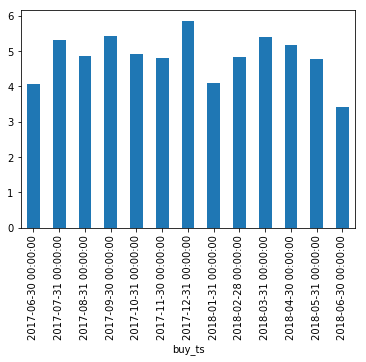

In [62]:
orders.groupby(pd.Grouper(key='buy_ts', freq='M'))['revenue'].mean().plot(kind='bar')

**Вывод:** Сумма среднего чека лежит в диапазоне от 1.22 до 4.89 денежных единиц.

Средний чек составил 5 денежных единиц. По гистограмме видно, что самый большой "средний чек" был в декабре. После чего в январе наблюдался резкий спад покупательской способности с постепенным ростом к марту. Возможно, на объем покупок сыграли роль предстоящие праздники, такие как Новый год и 8 марта. 

**Сколько денег приносят? (LTV)**

Для рассчета LTV сформируем когорты пользователей по месяцу первого заказа. Так как маржинальность нам неизвестна, то LTV будем считать только по выручке, то есть узнаем какую выручку приносят клиенты каждой когорты. 

1. Определим месяц первой покупки в таблице orders и суммарные расходы по каждому месяцу.

In [63]:
orders['order_month'] = orders['activity_date'].astype('datetime64[M]')
costs['month'] = costs['dt'].astype('datetime64[M]')

In [64]:
#определим месяц первой покупки каждого покупателя
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
first_orders.head()

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [65]:
#Посчитаем количество новых покупателей n_buyers за каждый месяц

cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2022
1,2017-07-01,1922
2,2017-08-01,1369
3,2017-09-01,2579
4,2017-10-01,4340


In [66]:
#добавим в таблицу с заказами месяц певрой покупки

orders_new = pd.merge(orders,first_orders, on='uid')
orders_new.head()

,buy_ts,revenue,uid,activity_date,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01


In [67]:
#Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа, просуммируем выручку по месяцам
cohorts_ltv = orders_new.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts_ltv.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [68]:
#добавим колонку с количеством новых пользователей в каждой когорте (по месяцу первого заказа)
report = pd.merge(cohort_sizes, cohorts_ltv, on='first_order_month')
report.head()

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2022,2017-06-01,9557.49
1,2017-06-01,2022,2017-07-01,981.82
2,2017-06-01,2022,2017-08-01,885.34
3,2017-06-01,2022,2017-09-01,1931.30
4,2017-06-01,2022,2017-10-01,2068.58


In [69]:
#рассчитаем "возраст" у когорт
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head()

,first_order_month,n_buyers,order_month,revenue,age
0,2017-06-01,2022,2017-06-01,9557.49,0
1,2017-06-01,2022,2017-07-01,981.82,1
2,2017-06-01,2022,2017-08-01,885.34,2
3,2017-06-01,2022,2017-09-01,1931.30,3
4,2017-06-01,2022,2017-10-01,2068.58,4


In [70]:
#теперь посчитаем выручку LTV по каждой когорте в каждом месяце ее "жизни"

report['ltv'] = report['revenue'] / report['n_buyers']
    
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
    
output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.726751,0.485569,0.437854,0.955143,1.02304,0.735865,0.950198,0.581879,0.553487,0.606088,0.571543,0.256983
2017-07-01,6.013345,0.335385,0.623855,0.359162,0.176883,0.156129,0.120271,0.141894,0.161316,0.147222,0.155754,
2017-08-01,5.280373,0.472337,0.458817,0.391563,0.494412,0.283747,0.210818,0.405303,0.292425,0.188115,,
2017-09-01,5.648907,1.11845,0.519938,3.97888,0.400869,0.647569,0.702152,0.243339,0.184149,,,
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.15156,0.120362,0.0848157,0.11547,,,,
2017-11-01,5.159358,0.398808,0.199703,0.325191,0.147903,0.0539186,0.115012,,,,,
2017-12-01,4.742434,0.260553,0.925731,1.066,0.313144,0.338279,,,,,,
2018-01-01,4.135636,0.294758,0.304281,0.142778,0.0626979,,,,,,,
2018-02-01,4.156987,0.278274,0.0785155,0.0741441,,,,,,,,


In [71]:
#какую выручку приносит каждый пользователь за каждый месяц жизни (из расчета на 12 месяцев выборки).
output.cumsum(axis=1).mean(axis=0)

age
0      4.803891
1      5.398152
2      5.824147
3      6.693058
4      7.302513
5      7.973689
6      8.392157
7      9.088187
8     10.068017
9      9.256415
10    10.009315
11    11.884397
dtype: float64

**Вывод:** В среднем в первый месяц новые покупатели делают заказы на 4,8 денежных единиц, а возвращаясь за новыми покупками в течение год "жизни" покупатель приносит 11,8 денежных единиц выручки.

Как быстро окупает каждый покупатель затраты, понесенные на его привлечение, рассчитаем на следующем этапе проекта "Маркетинг".

### Маркетинг<a id="marketing"></a>

**1. Сколько денег потратили? Всего / на каждый источник / по времени**

In [72]:
#сумма затрат за весь период

costs['costs'].sum()

329131.62

In [73]:
costs.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [74]:
#маркетинговые затраты по разным источникам: средняя по каждому источнику и общая сумма.
costs.groupby('source_id')['costs'].agg({'sum','mean'})

,mean,sum
source_id,,
1,57.391928,20833.27
2,117.922975,42806.04
3,389.315785,141321.63
4,168.246832,61073.60
5,142.189835,51757.10
9,15.199697,5517.49
10,16.039917,5822.49


In [75]:
#затраты по каждому месяцу с разбивкой по источнику

costs.pivot_table(index='month', columns='source_id', values='costs', aggfunc='sum')

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


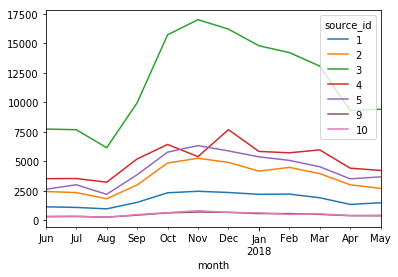

In [76]:
#график распределения маркетинговых затрат по видам источников привлечения

costs.pivot_table(index='month', columns='source_id', values='costs', aggfunc='sum').plot()

**Вывод:** Самым перспективным источником привлечения был выбран маркетологами источник №3, на него было потрачено больше всего рекламного бюджета.

По графику видно, что самые большие рекламные компании проводятся с осени по весну, в период наибольшей активности пользователей в интернете. 

**2. Сколько стоило привлечение одного покупателя из каждого источника?**

Для изучения этого вопроса будем использовать уже подготовленную выше таблицу по данным о пользователях, которые сделали хотя бы один заказ, то есть стали покупателями.

В ней есть данные о дате первого визита из определенного источника привлечения, откуда пользователь впервые пришел на сайт и в дальнейшем совершил покупку.

Зная объем затрат по источникам за каждый месяц, рассчитаем сколько стоило привлечение нового покупателя из каждого источника.

In [77]:
#определим все затраты по источникам

costs_per_source = costs.groupby('source_id')['costs'].sum().reset_index()
costs_per_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [78]:
#число покупателей в разрезе источников первого входа на сайт
customers_source = visits_customers_first_activity.groupby('source_id')['uid'].nunique().reset_index()
customers_source

,source_id,uid
0,1,2896
1,2,3503
2,3,10467
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1327


In [79]:
#объединим данные по затратам с количеством привлеченных клиентов
cost_per_user = customers_source.merge(costs_per_source, on='source_id')
cost_per_user

,source_id,uid,costs
0,1,2896,20833.27
1,2,3503,42806.04
2,3,10467,141321.63
3,4,10296,61073.60
4,5,6931,51757.10
5,9,1088,5517.49
6,10,1327,5822.49


In [80]:
cost_per_user['cac'] = round(cost_per_user['costs'] / cost_per_user['uid'], 2)
cost_per_user

,source_id,uid,costs,cac
0,1,2896,20833.27,7.19
1,2,3503,42806.04,12.22
2,3,10467,141321.63,13.50
3,4,10296,61073.60,5.93
4,5,6931,51757.10,7.47
5,9,1088,5517.49,5.07
6,10,1327,5822.49,4.39


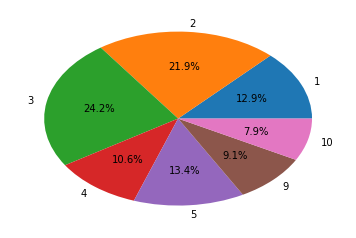

In [81]:
fig1, ax1 = plt.subplots()
ax1.pie(cost_per_user['cac'], labels=cost_per_user['source_id'], autopct='%1.1f%%')
plt.show()

**Вывод:** Дороже всего обходится привлечение клиентов по рекламным источникам №3 и №2. А самый дешевый трафик привлечения клиентов - источник №10.

**3. На сколько окупились расходы? (ROI)**

Для дальнейших рассчетов метрик, добавим в существующую таблицу с когортами заказов LTV сведения о расходах на маркетинг.

In [82]:
#ежемесячные расходы

monthly_costs = costs.groupby('month')['costs'].sum()
monthly_costs.head()

month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
Name: costs, dtype: float64

In [83]:
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new

,first_order_month,n_buyers,order_month,revenue,age,ltv,costs
0,2017-06-01,2022,2017-06-01,9557.49,0,4.726751,18015.00
1,2017-06-01,2022,2017-07-01,981.82,1,0.485569,18015.00
2,2017-06-01,2022,2017-08-01,885.34,2,0.437854,18015.00
3,2017-06-01,2022,2017-09-01,1931.30,3,0.955143,18015.00
4,2017-06-01,2022,2017-10-01,2068.58,4,1.023037,18015.00
...,...,...,...,...,...,...,...
73,2018-03-01,3534,2018-04-01,1063.05,1,0.300806,30415.27
74,2018-03-01,3534,2018-05-01,1114.87,2,0.315470,30415.27
75,2018-04-01,2274,2018-04-01,10600.69,0,4.661693,22289.38
76,2018-04-01,2274,2018-05-01,1209.92,1,0.532067,22289.38


In [84]:
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new.head()

,first_order_month,n_buyers,order_month,revenue,age,ltv,costs
0,2017-06-01,2022,2017-06-01,9557.49,0,4.726751,18015.0
1,2017-06-01,2022,2017-07-01,981.82,1,0.485569,18015.0
2,2017-06-01,2022,2017-08-01,885.34,2,0.437854,18015.0
3,2017-06-01,2022,2017-09-01,1931.30,3,0.955143,18015.0
4,2017-06-01,2022,2017-10-01,2068.58,4,1.023037,18015.0


In [85]:
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head()

,first_order_month,n_buyers,order_month,revenue,age,ltv,costs,cac
0,2017-06-01,2022,2017-06-01,9557.49,0,4.726751,18015.0,8.909496
1,2017-06-01,2022,2017-07-01,981.82,1,0.485569,18015.0,8.909496
2,2017-06-01,2022,2017-08-01,885.34,2,0.437854,18015.0,8.909496
3,2017-06-01,2022,2017-09-01,1931.30,3,0.955143,18015.0,8.909496
4,2017-06-01,2022,2017-10-01,2068.58,4,1.023037,18015.0,8.909496


In [86]:
report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

output.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,NaN
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,NaN,NaN
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.30,1.38,1.40,1.42,NaN,NaN,NaN
2017-10-01,0.60,0.66,0.68,0.70,0.72,0.74,0.75,0.76,NaN,NaN,NaN,NaN
2017-11-01,0.56,0.60,0.62,0.65,0.67,0.68,0.69,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.54,0.57,0.68,0.80,0.84,0.87,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.42,0.45,0.48,0.49,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.46,0.49,0.50,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
#посчитаем среднюю когорту по romi
output.cumsum(axis=1).mean(axis=0)

age
0     0.540835
1     0.582000
2     0.631070
3     0.719738
4     0.782942
5     0.859870
6     0.896780
7     0.969905
8     1.053814
9     0.964461
10    1.094618
11    1.333902
dtype: float64

Мы посчитали метрику ROMI и увидели, что в среднем окупаются вложения в пересчете на одного клиента за 9 месяцев.
Общий показатель окупаемости инвестиций рассчитаем по общим суммам выручки и затрат:

In [88]:
roi = (orders['revenue'].sum() - costs['costs'].sum()) / costs['costs'].sum() * 100
round(roi,1)

-23.4

**Вывод:** В среднем каждый клиент окупает маркетинговые затраты, понесенные на его привлечение, к 9 месяцу использования продукта.

В конце года наблюдаем убыток, это объясняется тем, что срок окупаемости маректинговых инвестиций достаточно долгий, поэтому прибыль от маркетинговых вложений будем ждать в следующем периоде.

## Вывод и рекомендации<a id="summary"></a>

За исследуемый период внушительные суммы вкладывались маркетологами в источик привлечения посетителей №3. Но он не принес ожидаемых результатов. Стоимость привлеченного покупателя по данному источнику самая высокая, а значит вложение в этот источник большей части рекламного бюджета неоправдано. 

Рекомендауем обратить внимание на источники №10, №9, №4. В предыдущей рекламной стратегии источник №10 был на последнем месте, но как оказалось, успешно привел клиентов-покупателей по самой низкой стоимости.

Метрика удержания клиентов "Retantion rate" показалось достаточно низкой. Уже через 2 недели - меньше 5% возвращаются на сайт. Но даже спустя месяц и год, этот показатель не падает до нуля, а держится в пределах 2-3%.
Такие показатели были бы смертельны для игр или соц.сетей, но отслеживать ежедневно афишу обычному человеку нет необходимости, поэтому считаем, что удержание клиентов успешно реализовано, но есть над чем работать. Например, "возвращать" пользователя рекомендациями в рассылках.

Так же стоит обратить внимание на удобство мобильной версии для покупок и источники привлечения мобильного трафика. По текущим данным более 70% пользователей заходят и совершают покупки на комьютере или ноутбуке.

Кроме уменьшения затрат на привлечение новых пользователей, можно также пересмотреть стратегию маркетинговых кампаний, например, стимулировать к единоразовым двойным покупкам и пр., что увеличит средний чек.

Эти шаги могут привести к сокращению срока окупаемости и росту прибыли.